### Data Preprocessing

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

house_df_org = pd.read_csv('Housing_advanced/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [44]:
print('data shape:', house_df.shape)
print('\n type of all features\n:', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\n Null columns and its frequency:\n', isnull_series[isnull_series>0].sort_values(ascending=False))

data shape: (1460, 81)

 type of all features
: object     43
int64      35
float64     3
dtype: int64

 Null columns and its frequency:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Count'>

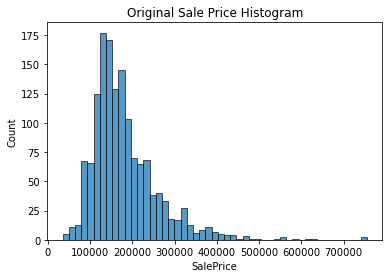

In [45]:
plt.title('Original Sale Price Histogram')
sns.histplot(house_df['SalePrice'])

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Count'>

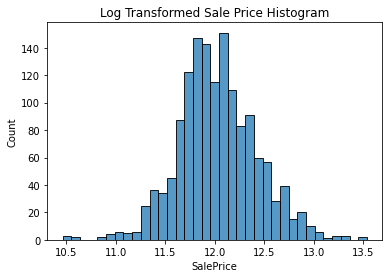

In [46]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice)

In [47]:
# SalePrice log transformation
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# drop columns which have lot of nulls
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1, inplace=True)
# fillna with mean
house_df.fillna(house_df.mean(), inplace=True)

null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('### Null feature type:\n', house_df.dtypes[null_column_count.index])

### Null feature type:
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [49]:
# One hot encoding for the object type columns
# get_dummies() changes null to None automatically
house_df_ohe = pd.get_dummies(house_df)
print('before one-hot-encoding:', house_df.shape)
print('after one-hot-encoding:', house_df_ohe.shape)

before one-hot-encoding: (1460, 75)
after one-hot-encoding: (1460, 271)


In [50]:
# Data types are now either float or int
house_df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 271 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(4), int64(33), uint8(234)
memory usage: 755.8 KB


### Linear regression model training/prediction/evaluation

In [56]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print('{0} log-transformed RMSE: {1}'.format(model.__class__.__name__, np.round(rmse,3)))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# linear regression training/predicting/evaluating
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression log-transformed RMSE: 0.132
Ridge log-transformed RMSE: 0.128
Lasso log-transformed RMSE: 0.176


[0.1318957657915436, 0.12750846334053045, 0.17628250556471395]

In [59]:
def get_top_bottom_coef(model):
    coef = pd.Series(model.coef_, index=X_features.columns)
    #top 10
    coef_high = coef.sort_values(ascending=False).head(10)
    #bottom 10
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

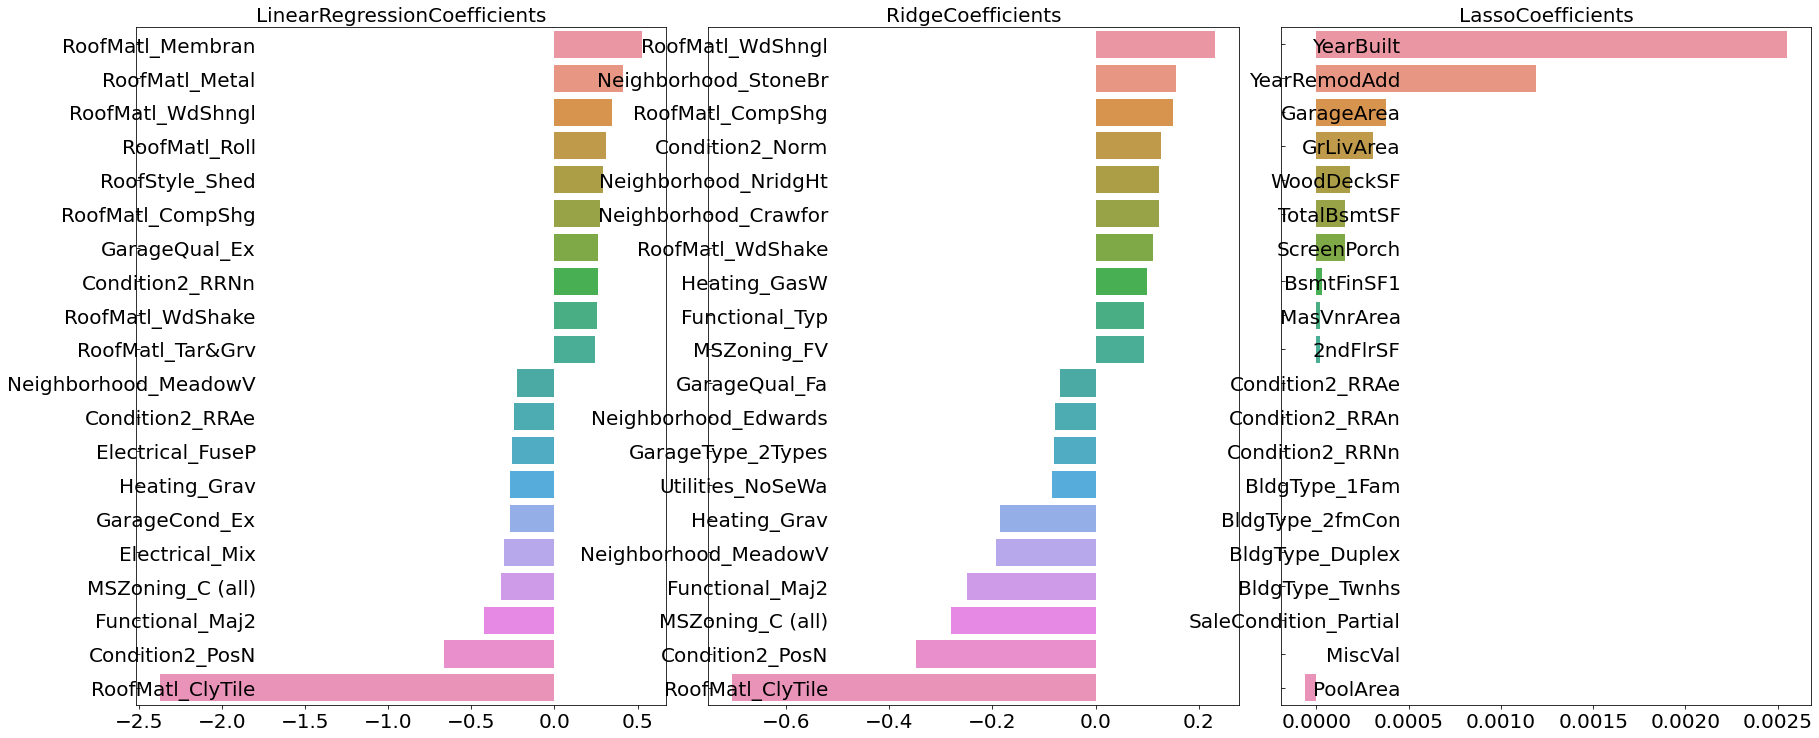

In [79]:
def visualize_coefficient(models):
    # 3 regresion model coefficient visualization
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i_num].set_title(model.__class__.__name__+'Coefficients', fontsize=20)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(20)            
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

* Why does the coefficients of Lasso looks different? Maybe data split was not appropriate?

In [80]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring = 'neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE list: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV average RMSE: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
        
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE list: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV average RMSE: 0.155

Ridge CV RMSE list: [0.117 0.154 0.142 0.117 0.189]
Ridge CV average RMSE: 0.144

Lasso CV RMSE list: [0.161 0.204 0.177 0.181 0.265]
Lasso CV average RMSE: 0.198


* Hyperparameter tuning is necessary

In [85]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-grid_model.best_score_)
    print('{0} 5 CV best average RMSE: {1}, best alpha: {2}'.format(
        model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))
    return grid_model.best_estimator_
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV best average RMSE: 0.1418, best alpha: {'alpha': 12}
Lasso 5 CV best average RMSE: 0.142, best alpha: {'alpha': 0.001}


LinearRegression log-transformed RMSE: 0.132
Ridge log-transformed RMSE: 0.124
Lasso log-transformed RMSE: 0.12


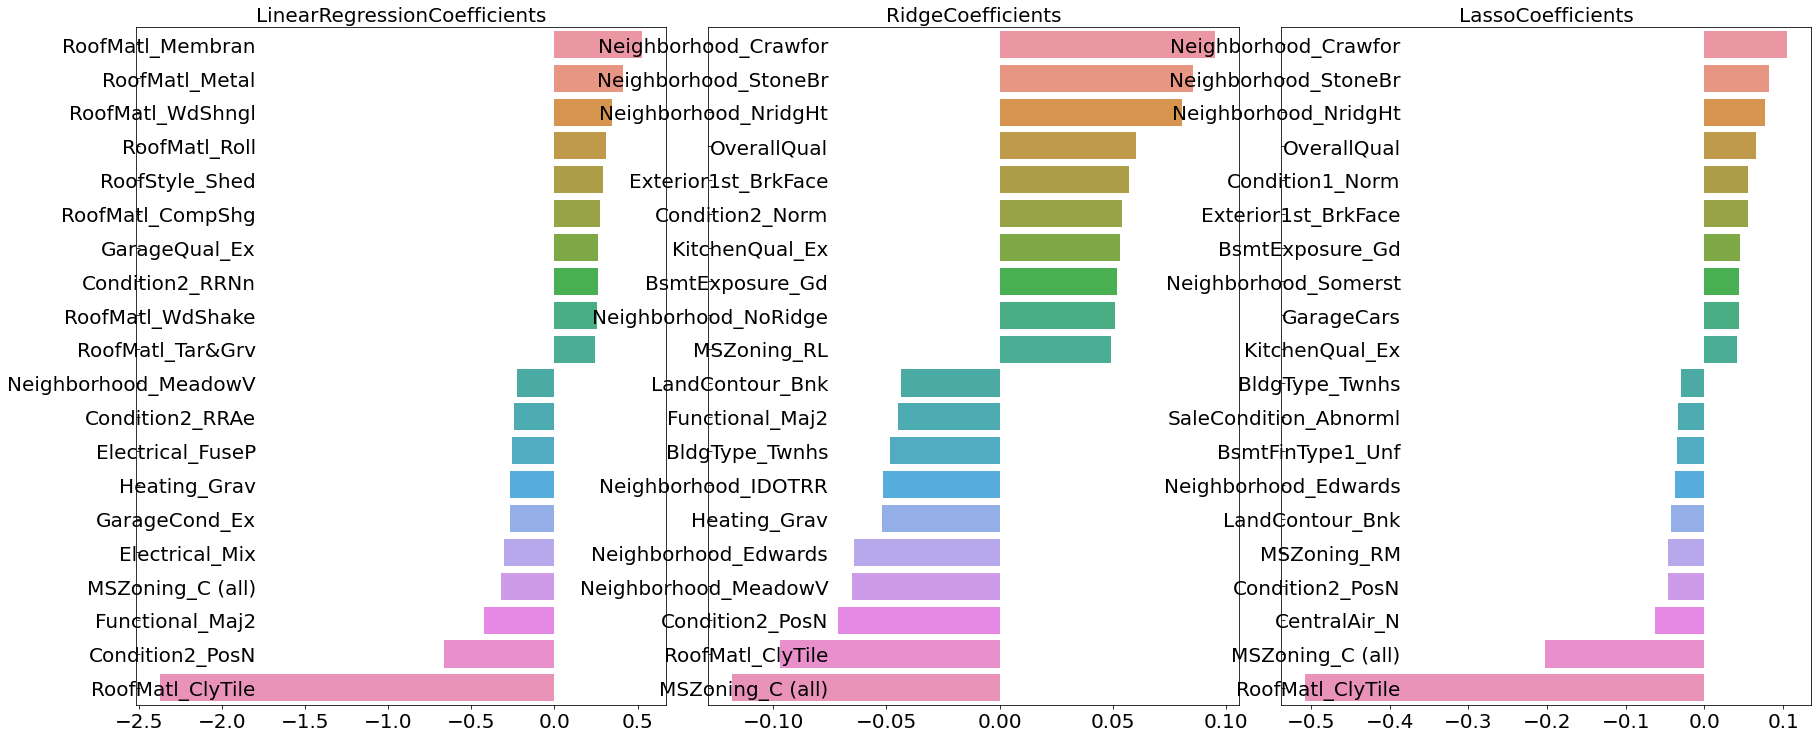

In [86]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

* using skew()

In [97]:
# skew needs to be applied only to the numerical feature (also need to exclude categorical feature encoded with one-hot encoding)
# if skew > 1 it can be considered as skewed dataset
from scipy.stats import skew

# numerical features
features_index = house_df.dtypes[house_df.dtypes!='object'].index
skew_features = house_df[features_index].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [99]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [109]:
# one-hot encoding again
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

#GridSearchCV again
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV best average RMSE: 0.1275, best alpha: {'alpha': 10}
Lasso 5 CV best average RMSE: 0.1252, best alpha: {'alpha': 0.001}


LinearRegression log-transformed RMSE: 0.128
Ridge log-transformed RMSE: 0.122
Lasso log-transformed RMSE: 0.119


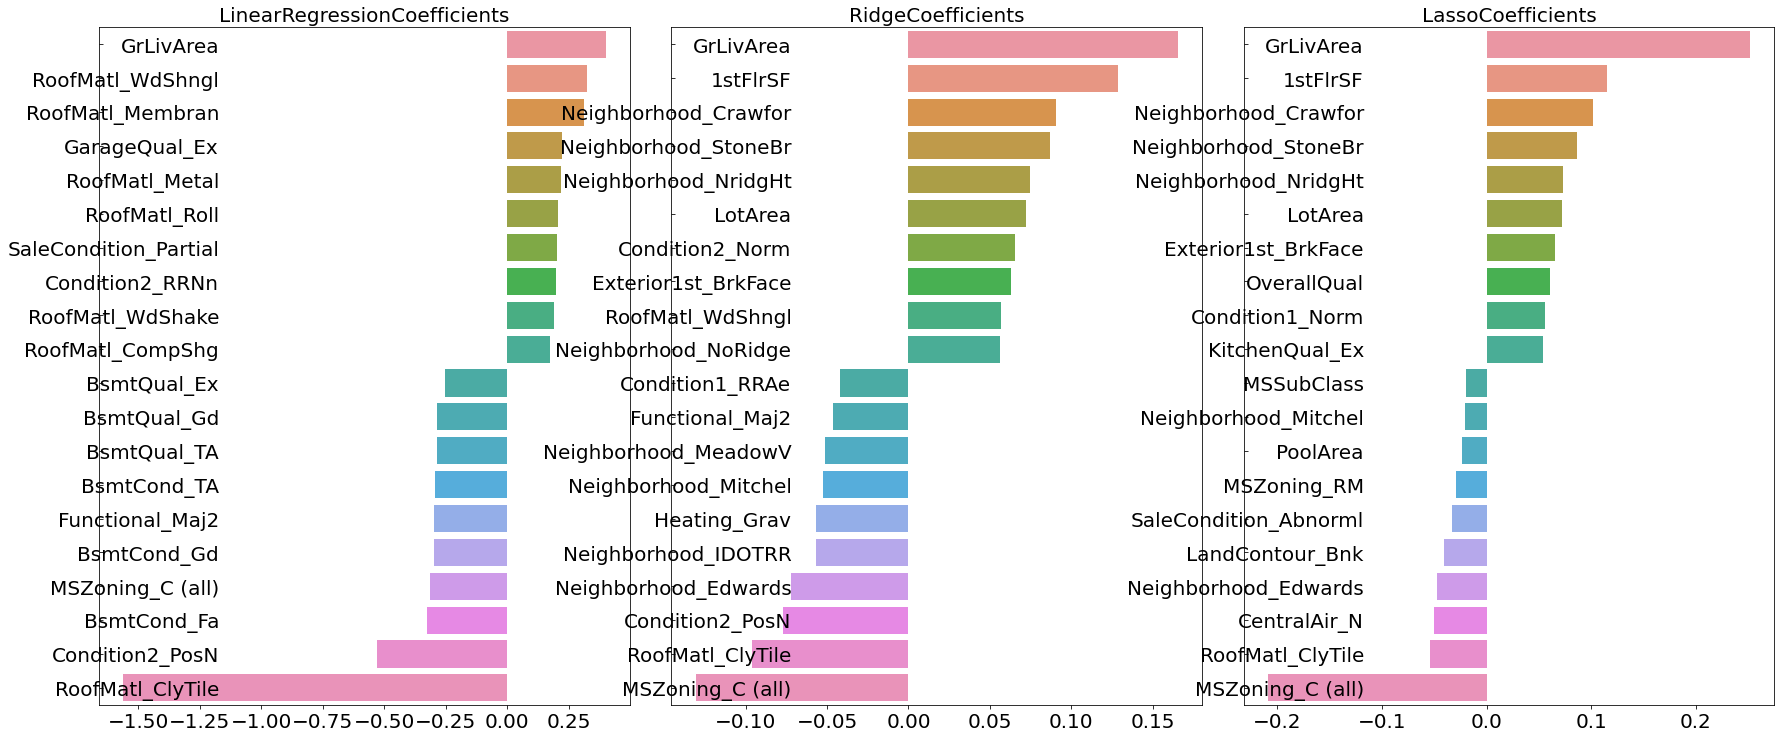

In [110]:
# training using best parameter
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# RMSE calculation
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# Coefficient Visualization
visualize_coefficient(models)

* outlier removal

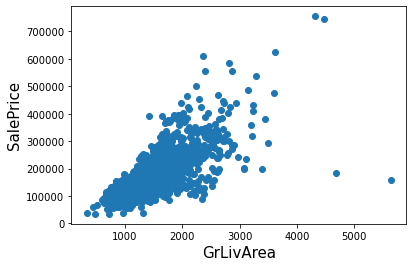

In [115]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [121]:
# Because log1p is applied GrLivArea, it should be considered when setting up to condition
# Area> 4000 and Price<500000 -> outlier
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1&cond2].index
print('outlier record index:', outlier_index.values)
print('shape before outlier removal:', house_df_ohe.shape)
house_df_ohe = house_df_ohe.drop(outlier_index, axis=0)
print('shape after outlier removal:', house_df_ohe.shape)

outlier record index: [ 523 1298]
shape before outlier removal: (1460, 271)
shape after outlier removal: (1458, 271)


In [123]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=156)
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV best average RMSE: 0.1125, best alpha: {'alpha': 8}
Lasso 5 CV best average RMSE: 0.1122, best alpha: {'alpha': 0.001}


LinearRegression log-transformed RMSE: 0.129
Ridge log-transformed RMSE: 0.103
Lasso log-transformed RMSE: 0.1


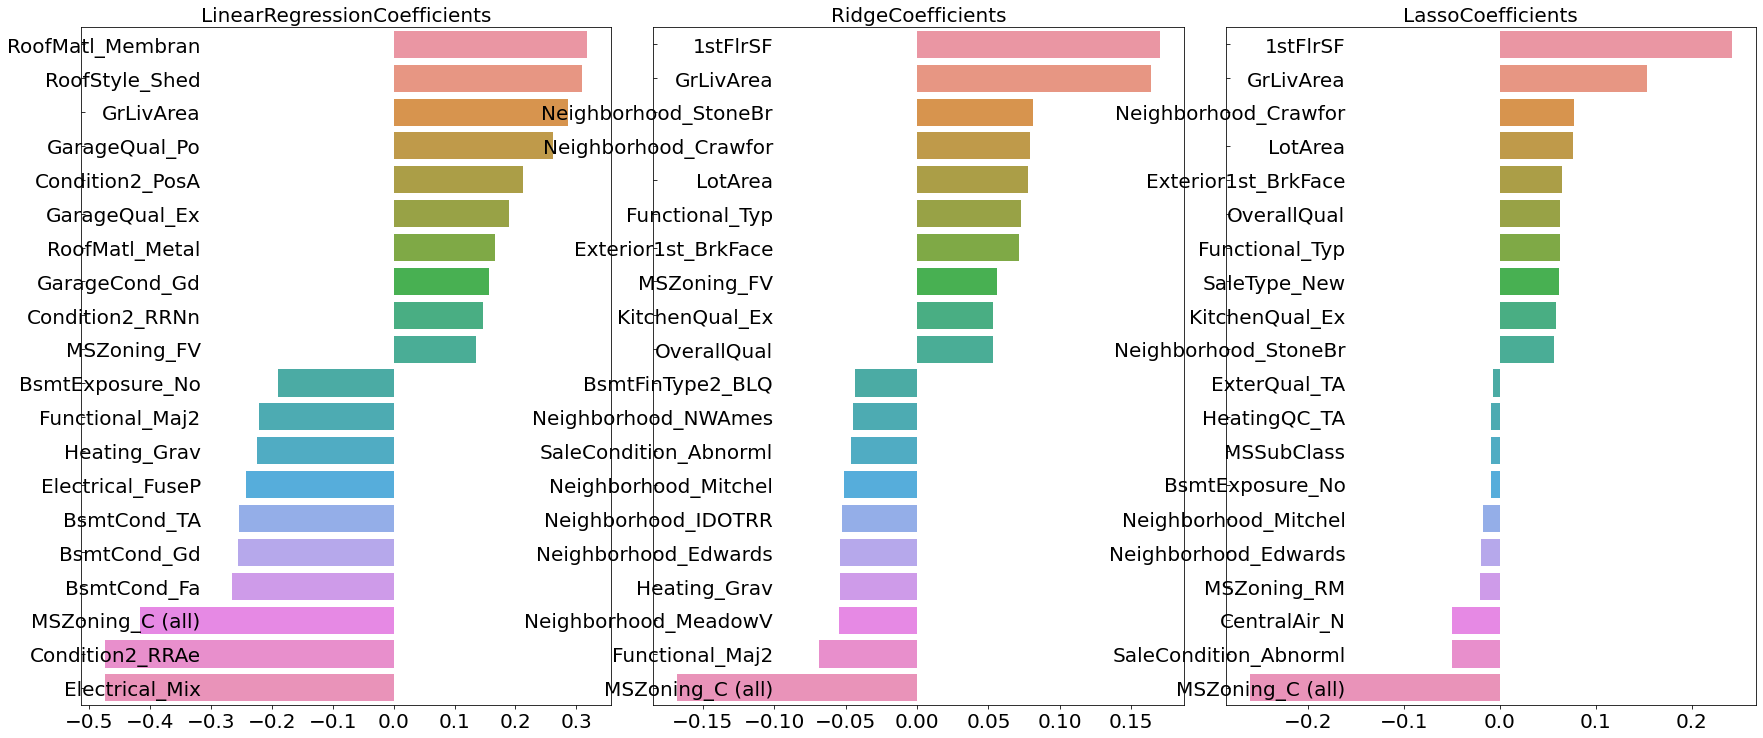

In [125]:
# using optimized classifier
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

### Tree-based Regression

In [129]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV best average RMSE: 0.1178, best alpha: {'n_estimators': 1000}


In [131]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV best average RMSE: 0.1163, best alpha: {'n_estimators': 1000}


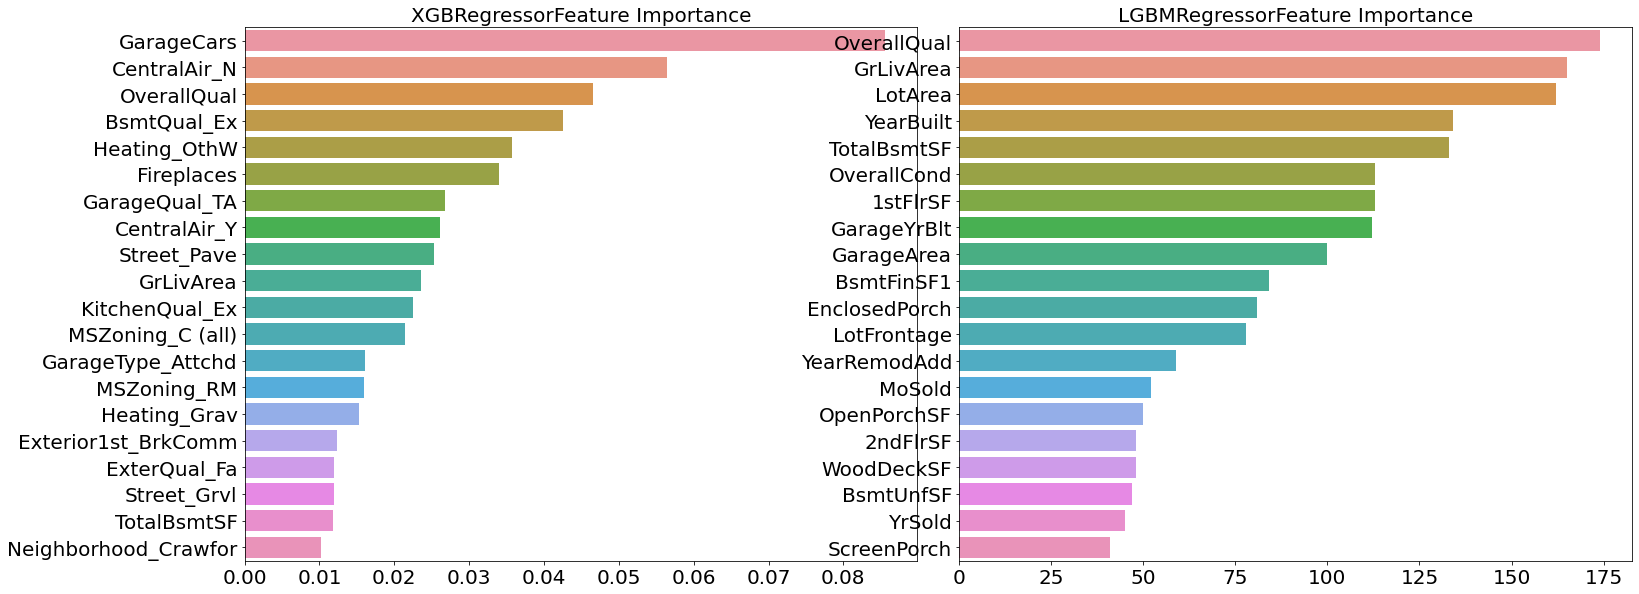

In [133]:
# feature importaces visualization
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(20,8), nrows=1, ncols=2)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+'Feature Importance', fontsize=20)
        #label font size
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(20)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index, ax=axs[i_num])

models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)               

### Model fusion (simply add results with certain weights)
* linear regression fusion

In [135]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} model RMSE: {1}'.format(key, rmse))
    
# training each model
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# prediction
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# fusion
pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'Fusion':pred,
         'Ridge':ridge_pred,
         'Lasso':lasso_pred}

# RMSE of fusion model, and each model
get_rmse_pred(preds)

Fusion model RMSE: 0.10007930884470519
Ridge model RMSE: 0.10345177546603272
Lasso model RMSE: 0.10024170460890039


* tree-based regression fusion

In [138]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                        colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                          subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred+0.5*lgbm_pred
preds = {'Fusion':pred,
         'XGBM':xgb_pred,
         'LGBM':lgbm_pred}
get_rmse_pred(preds)

Fusion model RMSE: 0.10170077353447762
XGBM model RMSE: 0.10738295638346222
LGBM model RMSE: 0.10382510019327311


### Stacking

In [143]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# for creating trining set and testing set for the final meta model
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf=KFold(n_splits=n_folds, shuffle=False)
    #ndarray initialization for returning 
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__, 'model start')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t fold:', folder_counter, 'start')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        # training using X_tr, y_tr
        model.fit(X_tr, y_tr)
        # prediction using validation test set
        train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
        # creating testing set using X_test_n
        test_pred[:, folder_counter] = model.predict(X_test_n)
    # averaging testing set
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    # returning training/testing set for the final meta model
    return train_fold_pred, test_pred_mean     
    

In [144]:
# Data transformation to ndarray
X_train_n = X_train.values
y_train_n = y_train.values
X_test_n = X_test.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, n_folds=5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, n_folds=5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, n_folds=5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, n_folds=5)

Ridge model start
	 fold: 0 start
	 fold: 1 start
	 fold: 2 start
	 fold: 3 start
	 fold: 4 start
Lasso model start
	 fold: 0 start
	 fold: 1 start
	 fold: 2 start
	 fold: 3 start
	 fold: 4 start
XGBRegressor model start
	 fold: 0 start
	 fold: 1 start
	 fold: 2 start
	 fold: 3 start
	 fold: 4 start
LGBMRegressor model start
	 fold: 0 start
	 fold: 1 start
	 fold: 2 start
	 fold: 3 start
	 fold: 4 start


In [147]:
# Data stacking for making training set and testing set
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# final meta model = lasso
meta_model_lasso = Lasso(alpha=0.0005)

# training, testing, evaluating meta model
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rsme = np.sqrt(mse)
print('Stacking regression RMSE:', rsme)

Stacking regression RMSE: 0.0979915296518969
